# Futura
## Example 1. Loading a pre-written recipe

Futura allows you to create customised versions of the ecoinvent database in a simple and transparent manner

In this example, you will load a recipe (written as a .yml file) and use it to create a new version of the ecoinvent database

The new version has the following arbitrary assumptions:
 - CCS has been invented
 - 50% of UK coal power is now post combustion CCS
 - 50% of German lignite power is now post combustion CCS

### Setup

In order to run this notebook you will need:
    - Futura installed on your machine
    - Wurst and Brightway2 installed on your machine (if they didn't automatically install as requirements for Futura)
    - A copy of 'example.yml' saved in the same folder as this notebook
    - A brightway2 project with a version of ecoinvent 3 as a database
    
You should open 'example.yml' in a text editor and change the lines at the top that look like this:
```
{% set base_project = "Prospective_LCA_1" %}
{% set base_database = "ecoinvent" %}
```
to point towards your brightway project and base version of ecoinvent 3

You can also edit the following line
```
{% set output_database = "ecoinvent_plus_CCS" %}
```
to give the database you will create a different name

### Step 1. Import the FuturaLoader class
Futura has a number of helpful classes, but for this example we will use the FuturaLoader, which loads recipes in order to create databases

*Note - you may get a warning saying Futura is using a monkeypatched version of Wurst - this is because Futura uses slightly tweaked versions of functions written for the excellent Wurst library - these will be submitted as a pull request in due course*

In [1]:
from futura.recipe_parser import FuturaLoader

futura      : WARNING  Futura is using a monkeypatched version of Wurst


### Step 2. Load a recipe into the FuturaLoader
We initialise the FuturaLoader with a recipe file. This is a plain text file written in YAML with optional templating via Jinja2.

These files are designed to be human readable and (technically) human writable, although as the futura project progresses and recipes become more complex they will be written by a GUI (in development).

There are (currently) four sections:
- metadata
    - provides infromation about the recipe file
- load
    - tells futura how to load the database(s) it needs to build the new version of ecoinvent
- technology
    - tells futura if and how to add, and regionalise new technologies to the database
- markets
    - tells futura how to alter markets within the new database, including adding producers, changing production volumes etc.

The recipe we are using here looks like this:

```
{% set base_project = "Prospective_LCA_1" %}
{% set base_database = "ecoinvent" %}
{% set output_database = "ecoinvent_plus_CCS" %}

metadata:
    base_project: {{base_project}}
    base_database: {{base_database}}
    output_database: {{output_database}}
    description: >
        This Futura recipe loads the ecoinvent 3.3 database, adds Carma CCS projects,
        then alters the British and German high voltage electricity markets to shift
        50% of coal and lignite produced electricity to CCS respectively
load:
    - extract_bw2_database:
        project_name: {{base_project}}
        database_names:
            - {{base_database}}
            
technology:
    - add_technology_to_database:
        technology_file: __ASSET_PATH__/lci-Carma-CCS-base-GLO2.xlsx
        funcs:
            - fix_ch_only_processes
            - add_hard_coal_ccs
            - add_lignite_ccs

markets:
    - alter_market:
        market_filter: [{'filter': 'equals', 'args': ['unit', 'kilowatt hour']},
                        {'filter': 'startswith', 'args': ['name', 'market']},
                        {'filter': 'contains', 'args': ['name', 'high']},
                        {'filter': 'equals', 'args': ['location', 'GB']}]
        tasks:
            - function: add_alternative_exchanges
              args: []
            - function: transfer_pv
              args:
                  - electricity production, hard coal
                  - Electricity, at power plant/hard coal, post, pipeline 200km, storage 1000m/2025
              kwargs:
                  factor: 0.5
            - function: relink
              args: []

    - alter_market:
          market_filter: [{'filter': 'equals', 'args': ['unit', 'kilowatt hour']},
                          {'filter': 'startswith', 'args': ['name', 'market']},
                          {'filter': 'contains', 'args': ['name', 'high']},
                          {'filter': 'equals', 'args': ['location', 'DE']}]
          tasks:
              - function: add_alternative_exchanges
                args: []
              - function: transfer_pv
                args:
                    - electricity production, lignite
                    - Electricity, at power plant/lignite, post, pipeline 200km, storage 1000m/2025
                kwargs:
                    factor: 0.5
              - function: relink
                args: []

```

By default, FuturaLoader will run the recipe it has been given on initialisation, you can turn this behaviour off using `autocreate=False`.
Here we have switched it off so we can look at the parsed version of the recipe before we run it.

In [2]:
f = FuturaLoader('example.yml', autocreate=False)

In [3]:
f.recipe

{'metadata': {'base_project': 'Prospective_LCA_1',
  'base_database': 'ecoinvent',
  'output_database': 'ecoinvent_plus_CCS',
  'description': 'This Futura recipe loads the ecoinvent 3.3 database, adds Carma CCS projects, then alters the British and German high voltage electricity markets to shift 50% of coal and lignite produced electricity to CCS respectively\n'},
 'load': [{'extract_bw2_database': {'project_name': 'Prospective_LCA_1',
    'database_names': ['ecoinvent']}}],
 'technology': [{'add_technology_to_database': {'technology_file': '__ASSET_PATH__/lci-Carma-CCS-base-GLO2.xlsx',
    'funcs': ['fix_ch_only_processes',
     'add_hard_coal_ccs',
     'add_lignite_ccs']}}],
 'markets': [{'alter_market': {'market_filter': [{'filter': 'equals',
      'args': ['unit', 'kilowatt hour']},
     {'filter': 'startswith', 'args': ['name', 'market']},
     {'filter': 'contains', 'args': ['name', 'high']},
     {'filter': 'equals', 'args': ['location', 'GB']}],
    'tasks': [{'function': 'a

### Step 3. Run the recipe
Ok, now we can run the recipe. This will take a few minutes, but you'll get progress updates as we go

In [4]:
f.run()

Getting activity data


  0%|                                                                                       | 0/501148 [00:00<?, ?it/s]

Adding exchange data to activities


100%|███████████████████████████████████████████████████████████████████████| 501148/501148 [00:32<00:00, 15209.89it/s]


Filling out exchange data


100%|██████████████████████████████████████████████████████████████████████████| 13831/13831 [00:03<00:00, 4427.51it/s]


Extracted 1 worksheets in 0.35 seconds
Applying strategy: link_iterable_by_fields
72 datasets
1398 exchanges
0 unlinked exchanges
  
Location data added to 0 activities
Location data added to 0 exchanges
Product data added to 785 exchanges
Default (zero) production volume data added to 72 production exchanges


  6%|████▉                                                                              | 1/17 [00:00<00:02,  5.44it/s]

Creating regionalised versions of hard coal CCS activities...


  0%|▏                                                                                | 2/1292 [00:00<01:56, 11.10it/s]

Relinking regionalised versions of hard coal CCS activities...


 12%|██████████▍                                                                        | 2/16 [00:00<00:01, 10.57it/s]

Creating regionalised versions of lignite CCS activities...


  0%|▎                                                                                 | 2/608 [00:00<00:51, 11.79it/s]

Relinking regionalised versions of lignite CCS activities...


100%|████████████████████████████████████████████████████████████████████████████████| 608/608 [01:10<00:00,  8.63it/s]


Applying add_alternative_exchanges
Applying transfer_pv with arguments electricity production, hard coal, Electricity, at power plant/hard coal, post, pipeline 200km, storage 1000m/2025 and keyword arguments factor:0.5
Applying relink
Applying add_alternative_exchanges
Applying transfer_pv with arguments electricity production, lignite, Electricity, at power plant/lignite, post, pipeline 200km, storage 1000m/2025 and keyword arguments factor:0.5
Applying relink


### Step 4. See what we've done
We'll import another couple of things from Futura, as well as Wurst, to see what our recipe has done

In [5]:
from futura.utils import create_filter_from_description
from futura.markets import FuturaMarket
import wurst as w

First we create a filter to find our altered markets for high voltage electricity in the UK and Germany

These are written as plain python descriptions and converted to wurst filters using a utility function from Futura. There's no real reason to do it this way, we could have written wurst filters directly. It's just to show how the filter descriptions in the recipe file are parsed within Futura.

In [6]:
filter_base = [{'filter': 'equals','args': ['unit', 'kilowatt hour']},
               {'filter': 'startswith', 'args': ['name', 'market']},
               {'filter': 'contains', 'args': ['name', 'high']},]

filter_gb = filter_base + [{'filter': 'equals', 'args': ['location', 'GB']}]
filter_de = filter_base + [{'filter': 'equals', 'args': ['location', 'DE']}]

filter_gb_w = create_filter_from_description(filter_gb)
filter_de_w = create_filter_from_description(filter_de)

Now we use wurst's `get_one` function to get a process from our new database, then feed it to a FuturaMarket class - a useful class for inspecting and making edits to markets in Futura

In [7]:
gb = w.get_one(f.database.db, *filter_gb_w)
gb_fm = FuturaMarket(gb, f.database)

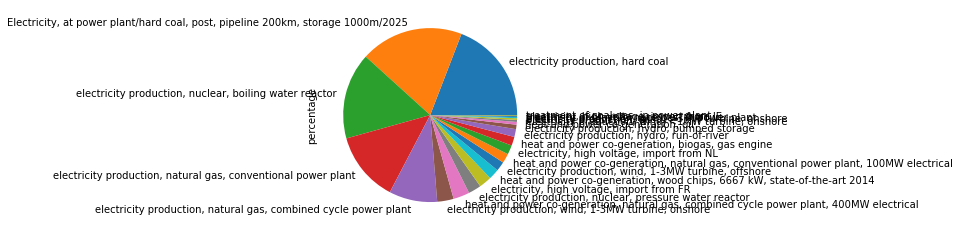

In [8]:
gb_fm.plot

We can see that we've successfully added post combustion Coal CCS as a major technology in the UK electricity market

Let's check Germany now

In [9]:
de = w.get_one(f.database.db, *filter_de_w)
de_fm = FuturaMarket(de, f.database)

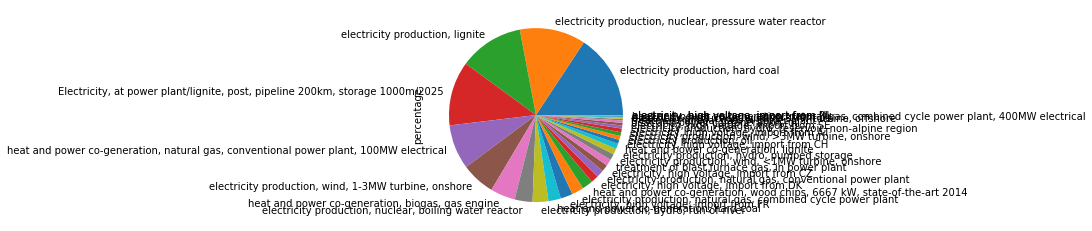

In [10]:
de_fm.plot

Same here - lignite CCS this time has been added to the grid mix for Germany. We can also see a percentage breakdown:

In [11]:
de_fm.sorted_percentages

,percentage
item,
"electricity production, hard coal",0.1573
"electricity production, nuclear, pressure water reactor",0.1226
"electricity production, lignite",0.1196
"Electricity, at power plant/lignite, post, pipeline 200km, storage 1000m/2025",0.1196
"heat and power co-generation, natural gas, conventional power plant, 100MW electrical",0.0827
"electricity production, wind, 1-3MW turbine, onshore",0.0629
"heat and power co-generation, biogas, gas engine",0.0460
"electricity production, nuclear, boiling water reactor",0.0332
"electricity production, hydro, run-of-river",0.0294


### Step 5. Write our new database to Brightway2

The FuturaLoader class has a built in method to write your new database to Brightway2

By default is uses the `base_project` and `output_database` set in the recipe, but you can change this by adding `project` and/or `database` arguments to the function call

In [12]:
f.write_database()

Deleting existing database ecoinvent_plus_CCS
Vacuuming database 
15807 datasets
547337 exchanges
0 unlinked exchanges
  


Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:01:47


Title: Writing activities to SQLite3 database:
  Started: 11/22/2019 15:18:44
  Finished: 11/22/2019 15:20:32
  Total time elapsed: 00:01:47
  CPU %: 60.30
  Memory %: 18.96
Created database: ecoinvent_plus_CCS


### Step 6. Check out our new database in Brightway
Lets run a quick LCA to see what's happened

*Note if you'll have to use the correct names for your projects and databases to run these cells*

In [14]:
from brightway2 import *

In [27]:
projects.set_current('Prospective_LCA_1')
original_ecoinvent = Database('ecoinvent')
new_ecoinvent = Database('ecoinvent_plus_CCS')
m = ('IPCC 2013', 'climate change', 'GTP 100a')

First lets look at UK high voltage electricity

In [45]:
original_gb_electricity = original_ecoinvent.search('market electricity high voltage GB')[0]
new_gb_electricity = new_ecoinvent.search('market electricity high voltage GB')[0]

original_lca = LCA({original_gb_electricity:1}, m)
original_lca.lci()
original_lca.lcia()

new_lca = LCA({new_gb_electricity:1}, m)
new_lca.lci()
new_lca.lcia()

In [44]:
print("UK grid electricity - original = {} kg CO2-eq/kWh".format(round(original_lca.score, 3)))
print("UK grid electricity - with CCS = {} kg CO2-eq/kWh".format(round(new_lca.score, 3)))

UK grid electricity - original = 0.566 kg CO2-eq/kWh
UK grid electricity - with CCS = 0.402 kg CO2-eq/kWh


Yep, that's changed

How about Germany?

In [46]:
original_de_electricity = original_ecoinvent.search('market electricity high voltage DE')[0]
new_de_electricity = new_ecoinvent.search('market electricity high voltage DE')[0]

original_de_lca = LCA({original_de_electricity:1}, m)
original_de_lca.lci()
original_de_lca.lcia()

new_de_lca = LCA({new_de_electricity:1}, m)
new_de_lca.lci()
new_de_lca.lcia()

In [47]:
print("Germany grid electricity - original = {} kg CO2-eq/kWh".format(round(original_de_lca.score, 3)))
print("Germany grid electricity - with CCS = {} kg CO2-eq/kWh".format(round(new_de_lca.score, 3)))

Germany grid electricity - original = 0.631 kg CO2-eq/kWh
Germany grid electricity - with CCS = 0.498 kg CO2-eq/kWh


Alright, but lets check that it's propagating through the database too by looking at something produced in Germany using electricity as an input

In [65]:
original_silicon = original_ecoinvent.search("silicon production", filter={'location':'DE'})[0]
new_silicon = new_ecoinvent.search("silicon production", filter={'location':'DE'})[0]

original_silicon_lca = LCA({original_silicon:1}, m)
original_silicon_lca.lci()
original_silicon_lca.lcia()

new_silicon_lca = LCA({new_silicon:1}, m)
new_silicon_lca.lci()
new_silicon_lca.lcia()

Excluding 76 filtered results
Excluding 76 filtered results


In [69]:
print("German silicon production - original = {} kg CO2-eq/kg".format(round(original_silicon_lca.score, 2)))
print("German silicon production - with CCS = {} kg CO2-eq/kg".format(round(new_silicon_lca.score, 2)))

German silicon production - original = 15.12 kg CO2-eq/kg
German silicon production - with CCS = 12.63 kg CO2-eq/kg


Alright! It's worked